In [7]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import libraries
import os
import pathlib
import pandas as pd
import numpy as np
import math
from scipy import special
import decimal
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds
from mpmath import *

os.chdir(pathlib.Path('C:/Users/asyzm/Desktop/').parent.absolute())

# Suppress scientific notation of floats
np.set_printoptions(suppress=True)

############################
## Data import & cleaning ##
############################

#Data import
prices = pd.read_csv('C:/Users/asyzm/Desktop/sp500.csv', na_values='#N/A N/A', index_col='Dates', parse_dates=True)
# Remove all columns that don't have 100% non NAN. This should clean dropped out stocks or latecomers
prices = prices.dropna(thresh=len(prices) * 1, axis=1)
tbill_yield = pd.read_csv('C:/Users/asyzm/Desktop/riskfreerate.csv', na_values='#N/A N/A', index_col='Dates', parse_dates=True)


# Convert 4 week treasury bill rate to daily rate
risk_free_daily = tbill_yield/36500
risk_free_daily = risk_free_daily[1:prices.shape[0]+1]

# Transform data to log returns
log_ret = np.subtract(np.log(prices/prices.shift(1)), np.tile(risk_free_daily, (1, prices.shape[1])))
log_ret = log_ret.iloc[1:]

#log_ret = pd.DataFrame(np.array(log_ret)-np.array(risk_free_daily[0:4125]))
#log_ret = log_ret.iloc[1:]

# Create small subset of data to work with initially. 10 time steps 10 stocks
excess_returns = log_ret.iloc[0:500,0:30]
excess_returns = pd.DataFrame(excess_returns)
#the size of rolling window
step = 100
run_times = math.floor(len(excess_returns)/step)
expected_return1list_cum = []
expected_return2list_cum = []
expected_return3list_cum = []

sharpe_ratio1list = []
sharpe_ratio2list = []
sharpe_ratio3list = []

cum_return1list = []
cum_return2list = []
cum_return3list = []

###############
## Main Loop ##
###############
for r in range(0,run_times):
    if r < run_times - 1:
        excess_returns_small = excess_returns.iloc[r*step:(r+1)*step,:]
    else:
        excess_returns_small = excess_returns.iloc[r*step:,:]
    # Initialize lists
    priorlist = []
    mulist = []
    confidence_meanlist = []
    confidence_covariancelist = []
    sigmalist = []
    liklist = []
    Problist = []
    Ulist = []
    Sigma_Kappalist = []
    cond_meanlist = []
    cond_varlist = []
    ##weight1 is nonrobust mean-variance portfolio choices, weight2 is robust bayesian-averaging portfolio choices
    weight1list = []
    weight2list = []

    return_cum1 = 0
    return_cum2 = 0
    return_cum3 = 0
    
    expected_return1list = []
    expected_return2list = []
    expected_return3list = []

    # Loop through time
    for t in range(len(excess_returns_small)):

        # Initialize prior values
        known_excess_returns = excess_returns_small.iloc[0:t,:]
        prior = np.zeros((t,1))
        confidence_mean = np.zeros((t,1))
        confidence_covariance = np.zeros((t,1))

        # Initialize parameters
        n = len(known_excess_returns.columns)
        mu = np.zeros((n,t))
        sigma = np.zeros((n,t*n))
        lik = np.zeros((t,1))
        Prob = np.zeros((t,1))
        weight1 = np.zeros((n,1))
        weight2 = np.zeros((n,1))
        q = np.zeros((t,1))
        U = np.zeros((t,1))


        if t == 0:
            print('Period', t+1, '/', len(excess_returns_small))

        # Initialize the parameter for model 1
        elif t == 1:

            # the prior probability at t=1 is set to be 1
            prior = 1
            priorlist.append(prior)

            # mu is set to be zero according to the remark at the bottom of page 1337
            mu0 = np.zeros((1, n), int)
            mu1 = 1/2 * excess_returns_small.iloc[0,:]
            mulist.append(mu1)

            # section 2.2 kappa and delta are initialized to be 1 when new model is born
            # lambda 0 and lambda 1 are set to be 0.0001 according to the remark at the bottom of page 1337
            confidence_mean0 = 2
            confidence_meanlist.append(confidence_mean0)

            # Common past sample mean
            lambda0 = 0.0001
            sigma0 = lambda0 * np.identity(n)
            sigma1 = 2 * sigma0 + np.outer(excess_returns_small.iloc[0,:],excess_returns_small.iloc[0,:])
            sigmalist.append(sigma1)

            # Common past sample Var
            confidence_covariance0 = 2
            confidence_covariancelist.append(confidence_covariance0)

            print('Period', t+1, '/', len(excess_returns_small))

        else:
            for i in range(0, t - 1):
                # ---------------------------------------------------------------------------------------- #
                # Update prior when a new model is born using sharing prior (section 3.1.4) with alpha = 1 #
                # ---------------------------------------------------------------------------------------- #
                for k in range(1, i + 2):
                    if t == 2:
                        prior[i] = prior[i] + 1 / (t - k + 1) * priorlist[t - 2]
                    else:
                        prior[i] = prior[i] + 1 / (t - k + 1) * priorlist[t - 2][k - 1]


                # ----------------------------------------------------------------------- #
                # Update model parameters when new information is available (section 3.2) #
                # ----------------------------------------------------------------------- #
                # for time step = 2
                if t == 2:
                    confidence_mean = [3,2]
                    confidence_covariance = [3,2]

                    # formula 7a - Mean
                    mu[:, i] = ((confidence_mean[i]-1) * mu1 + excess_returns_small.iloc[t - 1, :]) / (confidence_mean[i])

                    # formula 7b - Cov
                    sigma[:, i * n:(i + 1) * n] = ((confidence_covariance[i]-1) * (confidence_mean[i]) * sigmalist[t - 2][:,i * n:(i + 1) * n] + (confidence_mean[i]) * np.outer(excess_returns_small.iloc[1, :] - mu1, excess_returns_small.iloc[1, :] - mu1)) / ((confidence_covariance0 + 1) * (confidence_mean0 + 1))

                # for time step > 2
                else:
                    confidence_mean = [x + 1 for x in confidence_meanlist[t - 2]]
                    confidence_mean.append(2)

                    confidence_covariance = [x + 1 for x in confidence_covariancelist[t - 2]]
                    confidence_covariance.append(2)

                    # formula 7a - Mean
                    mu[:, i] = (((confidence_mean[i] - 1) * mulist[t - 2][:, i] + excess_returns_small.iloc[t - 1, :]) / (confidence_mean[i]))

                    # formula 7b - Cov
                    sigma[:, i * n:(i + 1) * n] = ((confidence_covariance[i] - 1) * confidence_mean[i] * sigmalist[t - 2][:,i * n:(i + 1) * n] + (confidence_mean[i]) * np.outer(excess_returns_small.iloc[t-1, :] - mulist[t - 2][:, i], excess_returns_small.iloc[t-1, :] - mulist[t - 2][:, i])) / ((confidence_covariance[i]) * (confidence_mean[i]))


            confidence_meanlist.append(confidence_mean)
            confidence_covariancelist.append(confidence_covariance)

            # According to section 3.1.4, when alpha = 1, the prior probability of model t is the same as that of model t-1
            prior[t - 1] = prior[t - 2]
            priorlist.append(prior)

            # At time t, there are two steps: first a new model is born (section 2.2), then the parameters are updated using newly observed excess return(section 3.2)

            # mu_new is the mean predicted for model t at time t-1 (section 2.2)
            mu_new = ((sum(excess_returns_small.iloc[0:t-1, :].mean(axis=0)) / n) * np.ones(((1, n)), int)).ravel()

            # mu[:,t-1] is the updated mu_new using formula 7a
            mu[:, t - 1] = ((confidence_mean[t-1] - 1) * mu_new + excess_returns_small.iloc[t-1, :]) / (confidence_mean[t - 1])
            mulist.append(mu)

            # Same steps applied to the updation of sigma
            # section 2.2
            if t == 2:
                lambda1 = 0.0001
                sigma_new = lambda1 * np.identity(n)

            else:
                lambda_i = np.zeros((n,t-1))

                for i in range(0, t - 1):
                    lambda_i[:,i] = np.array((1/(t-2)) * (excess_returns_small.iloc[i, :] - excess_returns_small.iloc[0:t - 1, :].mean(axis=0))**2)
                lambda_i = np.sum(lambda_i,axis=1)
                sigma_new = (np.sum(lambda_i) / n) * np.identity(n)

            # sigma[:,(t-1)*n:t*n] is the updated sigma_new using formula 7b
            sigma[:,(t-1)*n:t*n] = ((confidence_covariance[t - 1] - 1) * confidence_mean[t - 1] * sigma_new + (confidence_mean[t - 1]) * np.outer(excess_returns_small.iloc[t-1, :] - mu_new, excess_returns_small.iloc[t-1, :] - mu_new)) / ((confidence_covariance[t - 1]) * (confidence_mean[t - 1]))

            sigmalist.append(sigma)
            print('Period', t+1, '/', len(excess_returns_small))


            # ------------------------------------------------------------ #
            # Update model probabilities when new info arrives section 3.3 #
            # ------------------------------------------------------------ #

            # Likelihood Equation 8 p.1341
            try:
                for m in range(0,t):
                    kappa = confidence_mean[m]
                    delta = confidence_covariance[m]
                    nu = delta + n + 1
                    if m == t-1:    
                        log_a1 = n * math.log(100) + (n/2) * math.log(kappa-1) + ((nu - 1)/2) * math.log(np.linalg.det((delta-1) * sigma_new)*10000) + special.multigammaln(nu/2, n)
                        log_a2 = (n/2) * math.log(math.pi) + (n/2) * math.log(kappa)  + (nu / 2) * math.log(np.linalg.det(delta * sigmalist[t-1][:,(t-1)*n:t*n])*10000) + special.multigammaln((nu-1) / 2, n)
                        lik[m] = math.exp(log_a1 - log_a2)
                    else:
                        log_a1 = n * math.log(100) + (n/2) * math.log(kappa-1) + ((nu - 1)/2) * math.log(np.linalg.det((delta-1) * sigmalist[t-2][:,m * n:(m + 1) * n])*10000) + special.multigammaln(nu/2, n)
                        log_a2 = (n/2) * math.log(math.pi) + (n/2) * math.log(kappa)  + (nu / 2) * math.log(np.linalg.det(delta * sigmalist[t-1][:,m * n:(m + 1) * n])*10000) + special.multigammaln((nu-1) / 2, n)                
                        lik[m] = math.exp(log_a1 - log_a2)
                liklist.append(lik)
                # Bayes rule (bottom p.1340)
                sum_lik = sum(lik*prior)
                for i in range(0,t):
                    Prob[i] = (lik[i]*prior[i])/sum_lik
                prior = Prob
                priorlist[t-1] = prior
                Problist.append(Prob)
            except OverflowError:
                Prob = prior
                Problist.append(Prob)

            # ------------------------------------------------------- #
            # Robust Bayesian Averaging Portfolio choices section 5.2 #
            # ------------------------------------------------------- #

            # Equation 10
            cond_mean = np.dot(mu,Prob)
            cond_meanlist.append(cond_mean)

            # Equation 12
            Sigma_Kappa = np.zeros((n,n*t))
            for i in range(0,t):
                Sigma_Kappa[:,i*n:(i+1)*n] = ((1+confidence_mean[i])/(confidence_mean[i]))*sigma[:,i*n:(i+1)*n]
            Sigma_Kappalist.append(Sigma_Kappa)

            # Equation 11
            cond_var = np.zeros((n,n))
            for i in range(0,t):
                cond_var = cond_var + (Sigma_Kappa[:,i*n:(i+1)*n] + np.outer(mu[:,i-1], mu[:,i-1]))*Prob[i] - np.outer(cond_mean,cond_mean) 
            cond_varlist.append(cond_var)

            # Setup for equation 20 / 21
            ##non-robust MV portfolio weights are obtained
            theta = 1
            mean_equally = known_excess_returns.mean(axis=0)
            covariance_equally = np.zeros((n,n))
            for i in range(0,t):
                covariance_equally = covariance_equally + np.outer(np.array((excess_returns_small.iloc[i, :] - np.array(mean_equally)).transpose()),np.array((excess_returns_small.iloc[i, :] - np.array(mean_equally))))
            covariance_equally = 1/t * covariance_equally
            def nonrobust_op(w,theta,mean_equally,covariance_equally):
                return np.inner((np.array(w.dot(covariance_equally))),np.array(w)) - theta * np.inner(mean_equally,w)
            initial_weight = np.repeat(1/excess_returns_small.shape[1], excess_returns_small.shape[1])
            bounds = Bounds(0, 0.1)
            cons = ({'type': 'eq', 'fun': lambda x: 1 - sum(x)})
            sol_nonrobust = minimize(nonrobust_op, initial_weight, args = (theta,mean_equally,covariance_equally), method = 'SLSQP',constraints = cons,bounds = bounds)
            weight1list.append(sol_nonrobust.x)

            ##Calculation for robust bayesian portfolio choices
            
            tau = 4
            for i in range(0,t):
                q[i] = q[i] + 1 - theta * tau * weight2.transpose().dot(Sigma_Kappa[:,i*n:(i+1)*n].dot(weight2))

            # Equation 21.1
            def q(theta, tau, w, sigma_m):

                return 1 - theta * tau * w.dot(sigma_m).dot(w)

            # Equation 21.2
            def epsilon(w, mu_m, mu_head):
                return w.transpose().dot(np.subtract(mu_m, mu_head[:,0]))

            # Equation 21
            def U(tau, w, sigma_m, mu_m, mu_head, theta):

                if q(theta, tau, w, sigma_m) <= 0:
                    ret = 0
                    print("q error")
                else:
                    ret = (1 / math.sqrt(q(theta, tau, w, sigma_m))) * math.exp(((tau**2) * w.transpose().dot(sigma_m).dot(w) - 2 * tau * epsilon(w, mu_m, mu_head) + theta*tau*epsilon(w, mu_m, mu_head)**2) / (2 * q(theta, tau, w, sigma_m)))
                return ret

            # Equation 20
            def integral(tau, w, sigma, mu, mu_head, theta, prob):

                summe = 0             

                for i in range(0,t):
                    mu_m = mu[:,i]
                    sigma_m = Sigma_Kappa[:,i*n:(i+1)*n]

                    summe = summe + U(tau, w, sigma_m, mu_m, mu_head, theta) * prob[i]
                return summe

            # Equation 18
            def robust_mv_opt(w, cond_mean, R, tau, sigma, mu, mu_head, theta, prob):
                target_value = (w.dot(cond_mean) + R - 1/tau * math.log(integral(tau, w, sigma, mu, mu_head, theta, prob)))   
                return -target_value

            if t == 2:
                initial_guess = np.repeat(1/excess_returns_small.shape[1], excess_returns_small.shape[1])
            else:
                initial_guess = weight2list[t-3]

            # Update Parameters
            R = 0 #p.1341 nonrobust portfolio choices
            sigma = sigmalist[t-1]
            mu = mulist[t-1]
            mu_head = cond_mean
            prob = Problist[t-2]

            """
            if t == 2:
                initial_guess = np.repeat(1/excess_returns_small.shape[1], excess_returns_small.shape[1])
            else:
                initial_guess = weight2list[t-3]
            
            def robust_mv_opt(w,theta,cond_mean,cond_var):
                return np.inner((np.array(w.dot(cond_var))),np.array(w)) - theta * np.array(w).dot(np.array(cond_mean))
            """
            
            # Limits weights to be between 0 and 0.1
            bounds = Bounds(0,0.1)
            # Says one minus the sum of all variables must be zero
            cons = ({'type': 'eq', 'fun': lambda x: 1 - sum(x)})

            # Optimize
            sol = minimize(robust_mv_opt, initial_guess, args = (cond_mean, R, tau, sigma, mu, mu_head, theta, prob), method = 'SLSQP', constraints = cons, bounds = bounds)
            #sol = minimize(robust_mv_opt, initial_guess, args = (theta,cond_mean,cond_var), method = 'SLSQP', constraints = cons, bounds = bounds)
            print("nonrobust asset allocation:",sol_nonrobust)
            print("robust asset allocation:",sol)

            # Calculate excess returns for robust bayesian and comparison model
            weight2list.append(sol.x)
            print('Sum of weights Bayesian optimization: ',sum(sol.x))
            print('Sum of weights Standard model: ',sum(sol_nonrobust.x))

            # Model 1: Standard model | Model 2 Bayesian model
            expected_return1 = np.array(weight1list[t-3]).dot(excess_returns_small.iloc[t, :])
            expected_return1list.append(expected_return1)
            expected_return2 = weight2list[t-3].dot(excess_returns_small.iloc[t, :])
            expected_return2list.append(expected_return2)
            expected_return3 = 1/n *np.ones((1,n)).dot(excess_returns_small.iloc[t, :])
            expected_return3list.append(expected_return3)

            # Cumulative return
            return_cum1 = return_cum1 + expected_return1
            return_cum2 = return_cum2 + expected_return2
            return_cum3 = return_cum3 + expected_return3

           

    # Transform into df
    r1 = pd.DataFrame(expected_return1list)
    r2 = pd.DataFrame(expected_return2list)
    r3 = pd.DataFrame(expected_return3list)
    
    # Calculate annualized SR
    sharpe_ratio_1 = (sum(np.array(r1))/len(r1)) / np.std(np.array(r1)) * np.sqrt(252)
    sharpe_ratio_2 = (sum(np.array(r2))/len(r2)) / np.std(np.array(r2)) * np.sqrt(252)
    sharpe_ratio_3 = (sum(np.array(r3))/len(r3)) / np.std(np.array(r3)) * np.sqrt(252)
    
    sharpe_ratio1list.append(sharpe_ratio_1)
    sharpe_ratio2list.append(sharpe_ratio_2)
    sharpe_ratio3list.append(sharpe_ratio_3)
    
    expected_return1list_cum.append(expected_return1list)
    expected_return2list_cum.append(expected_return2list)
    expected_return3list_cum.append(expected_return3list)
    
    cum_return1list.append(return_cum1)
    cum_return2list.append(return_cum2)
    cum_return3list.append(return_cum3)
    # Output results
    print('------------------------------------------',
         '\nStandard model: ', 
         '\nSharpe ratio:', sharpe_ratio_1,
         '\nCumulative return:', return_cum1,
         '\n',
         '\nRobust Bayesian: ', 
         '\nSharpe ratio:', sharpe_ratio_2,
         '\nCumulative return:', return_cum2,
         '\n',
         '\nEqually Weighted: ', 
         '\nSharpe ratio:', sharpe_ratio_3,
         '\nCumulative return:', return_cum3,
         '\n-----------------------------------------')



Period 1 / 100
Period 2 / 100
Period 3 / 100
nonrobust asset allocation:      fun: 0.00011969633896840517
     jac: array([ 0.01379737,  0.00256545, -0.00908523,  0.00506565,  0.01082674,
        0.01094006,  0.01403256,  0.01633964,  0.01417948,  0.03145838,
        0.00861812,  0.02019792,  0.00426602, -0.00973106,  0.02868741,
        0.01419821,  0.01366885,  0.03250306,  0.03317767,  0.00780026,
        0.0357421 ,  0.00569559,  0.02120013,  0.01889891,  0.0226638 ,
        0.01623863,  0.01126942,  0.03114889, -0.00222039, -0.01163982])
 message: 'Optimization terminated successfully'
    nfev: 465
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0. , 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1,
       0.1, 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0. ,
       0. , 0. , 0.1, 0.1])
robust asset allocation:      fun: array([0.00018122])
     jac: array([ 0.00974642,  0.00195598, -0.0060809 ,  0.0036124 ,  0.00706921,
        0.007390

In [8]:
r1 = np.array(expected_return1list_cum[0])
for i in range(1,5):
    r1 = np.append(r1,np.array(expected_return1list_cum[i]))
r2 = np.array(expected_return2list_cum[0])
for i in range(1,5):
    r2 = np.append(r2,np.array(expected_return2list_cum[i]))
r3 = np.array(expected_return3list_cum[0])
for i in range(1,5):
    r3 = np.append(r3,np.array(expected_return3list_cum[i]))

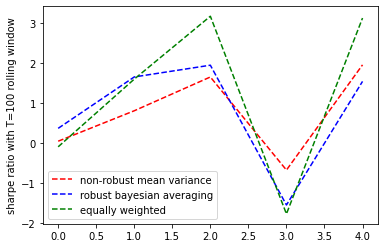

In [9]:
import matplotlib.pyplot as plt
plt.plot(sharpe_ratio1list,'r--',label = "non-robust mean variance")
plt.plot(sharpe_ratio2list,'b--',label = "robust bayesian averaging")
plt.plot(sharpe_ratio3list,'g--',label = "equally weighted")
plt.ylabel('sharpe ratio with T=100 rolling window')
plt.legend()
plt.show()

In [10]:
import csv
with open('expected return for periods 0-500.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(r1)
    wr.writerow(r2)
    wr.writerow(r3)

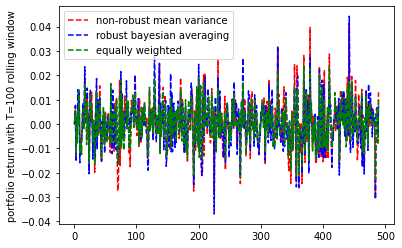

In [11]:
import matplotlib.pyplot as plt
plt.plot(r1,'r--',label = "non-robust mean variance")
plt.plot(r2,'b--',label = "robust bayesian averaging")
plt.plot(r3,'g--',label = "equally weighted")
plt.ylabel('portfolio return with T=100 rolling window')
plt.legend()
plt.show()

Text(0.5, 0, 'Date')

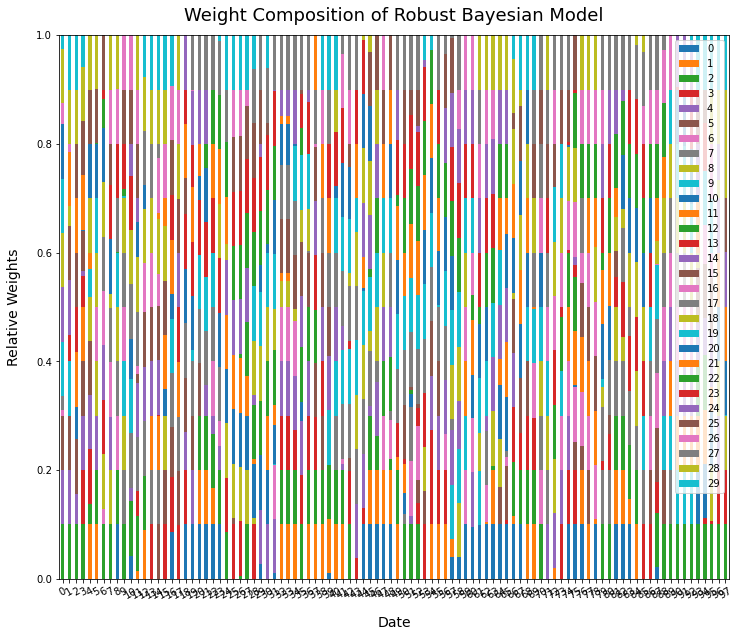

In [13]:
from matplotlib import pyplot as plt
pd.DataFrame(weight2list).plot(kind='bar', figsize=(12, 10), stacked=True)
plt.xticks(rotation=30)
plt.title("Weight Composition of Robust Bayesian Model", fontsize=18, y=1.015)
plt.ylabel("Relative Weights", fontsize=14, labelpad=15)
plt.xlabel("Date", fontsize=14, labelpad=15)

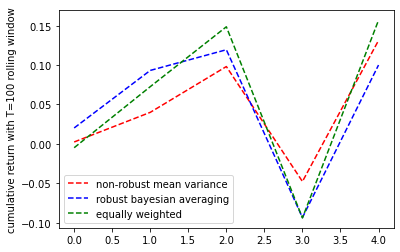

In [12]:
import matplotlib.pyplot as plt
plt.plot(cum_return1list,'r--',label = "non-robust mean variance")
plt.plot(cum_return2list,'b--',label = "robust bayesian averaging")
plt.plot(cum_return3list,'g--',label = "equally weighted")
plt.ylabel('cumulative return with T=100 rolling window')
plt.legend()
plt.show()